# Spam Trap Catcher for Drupal

## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import MySQLdb
from sshtunnel import SSHTunnelForwarder
import os
import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing import Process, Manager
import re

## SSH'ing inside the server we need to login into and obtaining the Dataframe:
### This will only be possible if your firewall allows server to server Tunnel Forwarding.
#### ssh -g -L 3306:127.0.0.1:3006 -f -N username@servername

In [2]:
#server = SSHTunnelForwarder(
#    'servername',
#    ssh_username="username",
#    ssh_password="password",
#    remote_bind_address=('127.0.0.1', 3306)
#)

#server.start()

#print(server.local_bind_port)  # show assigned local port
# work with `SECRET SERVICE` through `server.local_bind_port`.

#server.stop()

In [3]:
#db=MySQLdb.connect(host="127.0.0.1",port=server.local_bind_port,user="username_db",
#                  passwd="password_db",db="dbname")

In [4]:
#c=db.cursor()
#test=c.fetchmany(100)
#test='SELECT users.*,coalesce(user_settings.setting_value) AS biography, coalesce(signs.setting_value) AS signature FROM users LEFT OUTER JOIN user_settings ON (users.user_id = user_settings.user_id AND user_settings.setting_name="biography") LEFT OUTER JOIN user_settings AS signs ON (users.user_id = signs.user_id AND signs.setting_name="signature") GROUP BY users.user_id'

In [5]:
#dF=pd.read_sql(test,db)

In [6]:
#server.stop()

## Normal CSV file reading instead of Tunneling

In [7]:
dF=pd.read_csv("allusers_cat.csv") #name of the file

/home/hok14/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1) Spamwords

### 1-a) Spamword Set 1

### I have already done web scraping for this one and made it into a csv file

In [8]:
spamwords=pd.read_csv("spamwords.csv", index_col=0)

In [9]:
spamwords=spamwords[:447]

In [10]:
spamwords=spamwords.fillna("FREEE")

In [11]:
swords=spamwords["spam"].tolist()

In [12]:
temp=dF

In [13]:
temp["setting_value"]=temp["signature"].astype(str)+temp["biography"]
first=temp["user_id"].tolist()
second=temp["setting_value"].tolist()
third=[]
nan=np.nan
for x in range(0,len(first)):
    if(second[x] is nan):
        second[x]="0"
    third.append([first[x],second[x]])

In [14]:
def spam_count(user_id):
    #print(user_id[0])
    count=0
    trial=[]
    for x in range(0, len(spamwords)):
        temp_count=str(user_id[1]).count(str(swords[x]))
        if(temp_count>0):
            trial.append(str(swords[x]))
        count=temp_count+count
    #print(user_id[0],count,trial)
    return (user_id[0],count,trial)

p = Pool(16)
#list_val=temp[["user_id","setting_value"]].tolist()
t0=time.time()
at=p.map(spam_count,third)
t1=time.time()
total=t1-t0
print("Total time",total)

Total time 1.2494401931762695


In [15]:
users=[];
for x in range(0,len(at)):
    if(len(at[x][2])>0):
        users.append(at[x][0])

In [16]:
score_number_table1=[];
for x in range(0,len(at)):
    score_number_table1.append(at[x][1])

In [17]:
def spam_count(user_id):
    #print(user_id[0])
    count=0
    trial=[]
    for x in range(0, len(spamwords)):
        temp_count=0
        if str(swords[x]) in str(user_id[1]):
            temp_count=1
        else:
            temp_count=0
        if(temp_count>0):
            trial.append(str(swords[x]))
        count=temp_count+count
    #print(user_id[0],count,trial)
    return (user_id[0],count,trial)

p = Pool(16)
#list_val=temp[["user_id","setting_value"]].tolist()
t0=time.time()
at1=p.map(spam_count,third)
t1=time.time()
total=t1-t0
print("Total time",total)
p.close()

Total time 1.0260543823242188


In [18]:
score_table1=[];
for x in range(0,len(at1)):
    score_table1.append(at1[x][1])

### 1-b) Spamword Set 2

In [19]:
from bs4 import BeautifulSoup
import urllib.request
ra = urllib.request.urlopen("https://blog.hubspot.com/blog/tabid/6307/bid/30684/the-ultimate-list-of-email-spam-trigger-words.aspx")
r=ra.read()
soup = BeautifulSoup(r)
print(type(soup))
#print(soup.prettify()[0:1000000])

<class 'bs4.BeautifulSoup'>


/home/hok14/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/hok14/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [20]:
import numbers
#a=soup.table
trs=soup.findAll('tr')
#b=a[0].next_element
#print(b)
#i=0;
spam=[]
tables = soup.findAll("table")

for table in tables:
    if table.findParent("table") is None:
        a=str(table)
        soup2 = BeautifulSoup(a)
        for row in soup2.find_all("tr")[1:]:  #row by row
            col = row.find_all("td") # differentiating the td into columns.
            col = [ele.text.strip() for ele in col]
            #i=i+1;
            #print(i)
            try:                     #trying to convert them into strings.
                spam.append(str(col[0]))
                spam.append(str(col[1]))
                spam.append(str(col[2]))
                #spam.append(str(col[3])) ## I could've put them in a for loop
                # but then I would have to rewrite the code for try and except
            except OSError as err:
                print("OS error: {0}".format(err))
            except ValueError:
                print("Expected a string and got something else") 
            except:
                print("Unexpected error:", sys.exc_info()[0])
                raise
                #print(col)
                print("---")
            #print(spam)
        
print(spam)

['Buying judgments', 'Clearance', 'Order', 'Order status', 'Orders shipped by', 'shopper', 'Double your', 'Earn $', 'Earn extra cash', 'Earn per week', 'Expect to earn', 'Extra income', 'Home based', 'Home employment', 'Homebased business', 'Income from home', 'Make $', 'Make money', 'Money making', 'Online biz opportunity', 'Online degree', 'Opportunity', 'Potential earnings', 'University diplomas', 'While you sleep', 'Work at home', 'Work from home', 'Beneficiary', 'Best price', 'Big bucks', 'Cash', 'Cash bonus', 'Cashcashcash', 'Cents on the dollar', 'Cheap', 'Check', 'Claims', 'Collect', 'Compare rates', 'Cost', 'Credit', 'Credit bureaus', 'Discount', 'Earn', 'Easy terms', 'F r e e', 'Fast cash', 'For just $XXX', 'Hidden assets', 'hidden charges', 'Income', 'Incredible deal', 'Insurance', 'Investment', 'Loans', 'Lowest price', 'Million dollars', 'Money', 'Money back', 'Mortgage', 'Mortgage rates', 'No cost', 'No fees', 'One hundred percent free', 'Only $', 'Pennies a day', 'Price',

/home/hok14/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/hok14/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [21]:
def spam_count(user_id):
    #print(user_id[0])
    count=0
    trial=[]
    for x in range(0, len(spam)):
        temp_count=str(user_id[1]).count(str(spam[x]))
        if(temp_count>0):
            trial.append(str(swords[x]))
        count=temp_count+count
    #print(user_id[0],count,trial)
    return (user_id[0],count,trial)

p = Pool(16)
#list_val=temp[["user_id","setting_value"]].tolist()
t0=time.time()
at2=p.map(spam_count,third)
t1=time.time()
total=t1-t0
print("Total time",total)

Total time 0.9342660903930664


In [22]:
users2=[];
for x in range(0,len(at2)):
    if(len(at2[x][2])>0):
        users2.append(at2[x][0])

In [23]:
u12=0
for x in range(0,len(users)):
    for i in range(0, len(users2)):
        if(users[x]==users2[i]):
            u12=u12+1
            break;

In [24]:
score_number_table2=[];
for x in range(0,len(at2)):
    score_number_table2.append(at2[x][1])

In [25]:
def spam_count(user_id):
    #print(user_id[0])
    count=0
    trial=[]
    for x in range(0, len(spam)):
        temp_count=0
        if str(spam[x]) in str(user_id[1]):
            temp_count=1
        else:
            temp_count=0
        if(temp_count>0):
            trial.append(str(swords[x]))
        count=temp_count+count
    #print(user_id[0],count,trial)
    return (user_id[0],count,trial)

p = Pool(16)
#list_val=temp[["user_id","setting_value"]].tolist()
t0=time.time()
at3=p.map(spam_count,third)
t1=time.time()
total=t1-t0
print("Total time",total)
p.close()

Total time 0.8014814853668213


In [26]:
score_table2=[];
for x in range(0,len(at3)):
    score_table2.append(at3[x][1])

In [27]:
dF["score_number_table1"]=score_number_table1
dF["score_table1"]=score_table1
dF["score_table2"]=score_table2
dF["score_number_table2"]=score_number_table2

In [28]:
dF['score_table']=dF['score_table1']+dF['score_table2']
dF['score_number_table']=dF['score_number_table1']+dF['score_number_table2']

## 2) URLS in the biography and signature

In [29]:
from multiprocessing import Pool
from multiprocessing import Process, Manager
def spam_count(user_id):
    #print(user_id[0])
    count=0
    count=str(user_id[1]).count("http")
    #print(user_id[0],count,trial)
    return (user_id[0],count)

p = Pool(16)
#list_val=temp[["user_id","setting_value"]].tolist()
t0=time.time()
at4=p.map(spam_count,third)
t1=time.time()
total=t1-t0
print("Total time",total)

Total time 0.08834314346313477


In [30]:
temp=[]
for x in range(0,len(at)):
    temp.append(at4[x][1])

In [31]:
dF["links"]=temp

In [32]:
#dF["links"].hist()
bins = np.linspace(0, 10, 40) # Starts with 0, last one is 3, 
avg=sum(temp)/len(temp)
print("The average is", avg,"Max is", max(temp))

The average is 1.0809283183996665 Max is 325


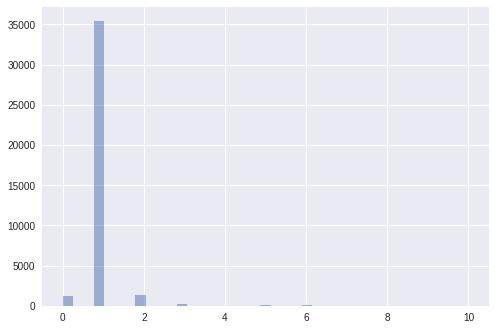

In [33]:
plt.hist(temp,bins, alpha=0.5, histtype='bar')
plt.show()

In [34]:
above0=len(dF[dF["links"]>0])
above1=len(dF[dF["links"]>1])
print("more than 0",above0,"more than 1",above1)

more than 0 37143 more than 1 1740


### 0 is 0, 1 is 1, >1 is 2

In [35]:
temp_store=[]
for x in range(0,len(temp)):
    if(temp[x]==0):
        temp_store.append(temp[x])
    elif(temp[x]==1):
        temp_store.append(temp[x])
    else:
        temp_store.append(2)

In [36]:
len(temp_store),max(temp_store),min(temp_store)

(38392, 2, 0)

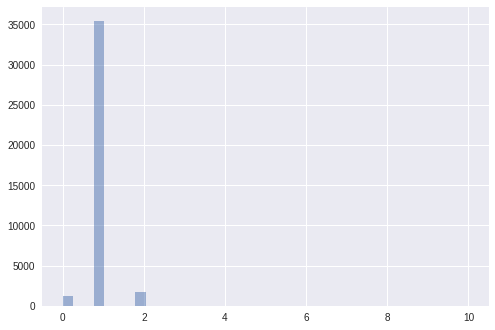

In [37]:
plt.hist(temp_store,bins, alpha=0.5, histtype='bar')
plt.show()

## Also, adding the links and setting value which is biography + signature to the dataframe.

In [38]:
dF["setting_value"]=dF["signature"].astype(str)+dF["biography"]
dF["links"]=temp_store

The first table of spam words, the score_number_table1, is the number of times the spam words did occur in that setting_value. The score_table1 is the number of spam words used in the setting_value.

The second table of spam words, the score_number_table2, is the number of times the spam words did occur in that setting_value. The score_table2 is the number of spam words used in the setting_value.

## 3) Regular expressions in the email- regex [a-z,A-z,_-.]+[0-9]


In [39]:
emailRegex = re.compile('^[a-zA-Z._-]{3,30}[0-9]{0,4}$', re.VERBOSE)

In [40]:
temp=dF["email"].str.contains('edu',case=False)
count=0
temp_store=[]
for x in range(0,len(dF)):
    user=str(dF["email"].iloc[x])
    user=user.split('@')[0]
    final=re.search(emailRegex, str(user), flags=0)
    if(temp.iloc[x]):
        count=count+1
        temp_store.append(1)
    else:
        if(final!=None):
            count=count+1
            temp_store.append(1)
        else:
            temp_store.append(0)

In [41]:
dF["regex"]=temp_store

## 4) Adding URL's which have been used more than 1 time and do not have edu at the end or .edu. or ends with edu or .edu/

In [42]:
dF['url']=dF['url'].fillna('0')

In [43]:
dFn=dF.groupby(dF["url"]).size().to_frame('count').reset_index()
dFn=dFn[dFn["count"]>1]
dFn=dFn.sort_values("count", ascending=False)
dFn=dFn[dFn["url"].str.contains('http')]
dFn=dFn[dFn["url"].str.contains('orcid')==False]
dFn=dFn[dFn["url"].str.contains('.edu.',regex=False)==False]
dFn=dFn[dFn["url"].str.contains('.edu/',regex=False)==False]
dFn=dFn[dFn["url"].str.endswith('edu')==False]
#dFn[dFn["url"].str.contains('edu')]
dFn=dFn.reset_index()
dFn=dFn[["url","count"]]
print("This is the total",dFn["count"].sum(),"Total number of URLs",len(dFn))
dFn=dFn["url"].tolist()

This is the total 10871 Total number of URLs 2928


In [44]:
urls=dF['url'].tolist()

In [45]:
import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing import Process, Manager
def spam_count(url):
    #print(user_id[0])
    a=0
    for x in range(0, len(dFn)):
        if(dFn[x]==url):
            a=1
            break;
    return a

p = Pool(16)
#list_val=temp[["user_id","setting_value"]].tolist()
t0=time.time()
at5=p.map(spam_count,urls)
t1=time.time()
total=t1-t0
print("Total time",total)

Total time 0.532719612121582


### Adding the spam urls to the dataframe


In [46]:
dF["spam_urls"]=at5

## 5) email addresses ending with .edu or has .edu.


In [47]:
temp=(dF['email'].str.endswith("edu", na=False)) | (dF["url"].str.contains('.edu.',regex=False))

In [48]:
temp=temp.tolist()

In [49]:
at6=[]
for x in range(0,len(temp)):
    if(temp[x]==True):
        at6.append(1)
    else:
        at6.append(0)

In [50]:
dF["edu_emails"]=at6

## 6) Similar names case: 'first_name' = last_name' OR 'middle_name'='last_name' OR 'middle_name'='first_name'

In [51]:
temp=(dF['first_name']==dF['last_name']) | (dF['middle_name']==dF['last_name']) | (dF['middle_name']==dF['first_name'])

In [52]:
temp=temp.tolist()

In [53]:
at7=[]
for x in range(0,len(temp)):
    if(temp[x]==True):
        at7.append(1)
    else:
        at7.append(0)

In [54]:
dF["flmname"]=at7

## 7) Scholarly words used in the setting value

In [55]:
dF1=pd.read_csv("term_frequency.csv",encoding = "utf-8",index_col=0)

In [56]:
dF2=pd.read_csv("setting_value.csv")

/home/hok14/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
dF2=dF2[(~dF2.setting_value.isnull()) & (dF2.email.str.contains("edu"))][:100]

In [58]:
temp=dF2.setting_value.str.split(expand=True).stack().value_counts()

In [59]:
right_words1=[]
right_words2=[]
for x in range(0,len(temp)):
    #print(x)
    for i in range(1,len(dF1)):
        #print(str(dF1.column.loc[i]),str(temp.index[x]))
        if(str(dF1.column.loc[i])==str(temp.index[x])):
            #print("do nothing")
            break;
        if(i==(len(dF1)-1)):
            right_words1.append(temp[x])
            right_words2.append(temp.index[x])
            #print(str(temp.index[x]))

In [60]:
d = {'total_count': right_words1, 'value': right_words2}

In [61]:
temp2=pd.DataFrame(data=d) 

In [62]:
temp2["value"]=temp2["value"].str.replace("nan","")
temp2["value"]=temp2["value"].str.replace(".","")
temp2["value"]=temp2["value"].str.replace(",","")
temp2["value"]=temp2["value"].str.replace('"',"")

In [63]:
temp3=temp2.groupby("value").sum()
temp4=temp3[temp3["total_count"]>4].sort_values("total_count")
temp4=temp4.reset_index()

In [64]:
#temp4.to_csv("actual_words.csv")

In [65]:
temp4=temp4["value"].tolist()

### Filtering the high frequency words by removing the most commonly used words.

In [66]:
dF2=dF

In [67]:
first=dF2["user_id"].tolist()
second=dF2["setting_value"].tolist()
third=[]
nan=np.nan
for x in range(0,len(first)):
    if(second[x] is nan):
        second[x]="0"
    third.append([first[x],second[x]])

In [68]:
len(third)

38392

In [69]:
import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing import Process, Manager

def spam_count(user_id):
    #print(user_id[0])
    count=0
    trial=[]
    for x in range(0, len(temp4)):
        temp_count=0
        if str(temp4[x]) in str(user_id[1]):
            temp_count=1
        else:
            temp_count=0
        if(temp_count>0):
            trial.append(str(temp4[x]))
        count=temp_count+count
    #print(user_id[0],count,trial)
    return (user_id[0],count,trial)

p = Pool(16)
#list_val=temp[["user_id","setting_value"]].tolist()
t0=time.time()
#print(third)
at3=p.map(spam_count,third)
t1=time.time()
total=t1-t0
print("Total time",total)
p.close()

Total time 0.3451364040374756


In [70]:
arr=[]

for x in range(0,len(at3)):
    if((at3[x][1])>0):
        arr.append(1)
    else:
        arr.append(0)

In [71]:
dF2["score_truth_table"]=arr

In [72]:
dF["score_truth_table"]=dF2["score_truth_table"]

## 8) Jaccard distance with n-grams set to 3

In [73]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]',r'', string)
    string=string.lower()
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

In [74]:
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    try:
        check=intersection_cardinality/float(union_cardinality)
    except:
        check=0
    return check

In [75]:
temp=dF

### 8.1) First name and Last name with username

In [76]:
temp["given_name"]=temp["first_name"].astype(str)+temp["last_name"]

In [77]:
arr=[]

for x in range(0, len(temp)):
    a=str(temp.iloc[x].given_name)
    a=ngrams(a)
    b=str(temp.iloc[x].username)
    b=ngrams(b)
    #print(a,b)
    arr.append(jaccard_similarity(a,b))    

In [78]:
temp["jaccard"]=arr

### 8.2) First name and last name with email before @

In [79]:
temp["email"]=temp.email.str.extract("(.*)@")

/home/hok14/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [80]:
arr2=[]

for x in range(0, len(temp)):
    a=str(temp.iloc[x].given_name)
    a=ngrams(a)
    b=str(temp.iloc[x].email)
    b=ngrams(b)
    #print(a,b)
    arr2.append(jaccard_similarity(a,b))

In [81]:
temp["jaccard2"]=arr2

### 8.3) Username and email

In [82]:
arr3=[]

for x in range(0, len(temp)):
    a=str(temp.iloc[x].username)
    a=ngrams(a)
    b=str(temp.iloc[x].email)
    b=ngrams(b)
    #print(a,b)
    arr3.append(jaccard_similarity(a,b))

In [83]:
temp["jaccard3"]=arr3

In [84]:
temp["jaccard_final"]=(temp["jaccard"]<0.1) & (temp["jaccard2"]<0.1) & (temp["jaccard3"]<0.1)

In [85]:
temp["jaccard_final"]=temp["jaccard_final"].astype(int)

In [86]:
dF["jaccard_final"]=temp["jaccard_final"]

## The final decision tree which gives us the spam users based on the conditions above:

In [87]:
spammers=dF[
    ((dF["edu_emails"]==0) 
    & ((dF["jaccard_final"]==1)|(dF["flmname"]==1))
    & ((dF["regex"]==0)|dF["links"]>0)) 
    & ((dF["links"]>0)|(dF["spam_urls"]==1) 
       | ((dF["score_table"]==1)
          & (dF["score_truth_table"]==0)))
]

In [88]:
spammers.to_csv("cat_tom.csv")

In [89]:
len(dF)

38392

In [90]:
len(spammers)

33955

In [91]:
len(dF)-len(spammers)

4437

In [92]:
#33955